In [1]:
INSTALL_PACKAGES = False

# we're going to use tensorflow 2.14.0 and keras 2.14.0 because that's probably what the tutorial used
# https://developer.apple.com/metal/tensorflow-plugin/
# KerasCV installation: https://keras.io/keras_cv/#keras-2-installation
if INSTALL_PACKAGES:
    !pip install tensorflow==2.14.0 tensorflow-metal keras-cv opencv-python pycocotools matplotlib

In [2]:
# setup
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


# Load Data

In [3]:
# hyperparameters
#SCALE_MAX = 1.3
#SCALE_MIN = 0.75
SCALE_MAX = 1.0
SCALE_MIN = 1.0
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCHS = 3
GLOBAL_CLIPNORM = 10.0

In [4]:
# map class names to unique integer identifier
class_ids = [
    "Bud",
#    "Leaf",
#    "Stem",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_annot = "data/annotations/"
path_images = "data/images/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [5]:
# export PascalVOC images + annotations from Label Studio

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

#print(classes)
#print(bbox)

  0%|          | 0/27 [00:00<?, ?it/s]

In [6]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

2024-03-15 11:04:13.035544: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-15 11:04:13.035567: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-15 11:04:13.035570: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-15 11:04:13.035621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 11:04:13.035654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [8]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [9]:
# Resizes images to 640x640 while maintaining aspect ratio.
# The bounding boxes associated with the image are specified in the xyxy format.
# If necessary, the resized image will be padded with zeros to maintain the original aspect ratio.

augmenter = keras.Sequential(
    layers=[
#        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
#        keras_cv.layers.RandomShear(
#            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
#        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(SCALE_MIN, SCALE_MAX),
            bounding_box_format="xyxy"
        ),
    ]
)

# Creating Training Dataset

In [10]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# Creating Validation Dataset

In [11]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(SCALE_MIN, SCALE_MAX),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

# Visualization

2024-03-15 11:04:15.889128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


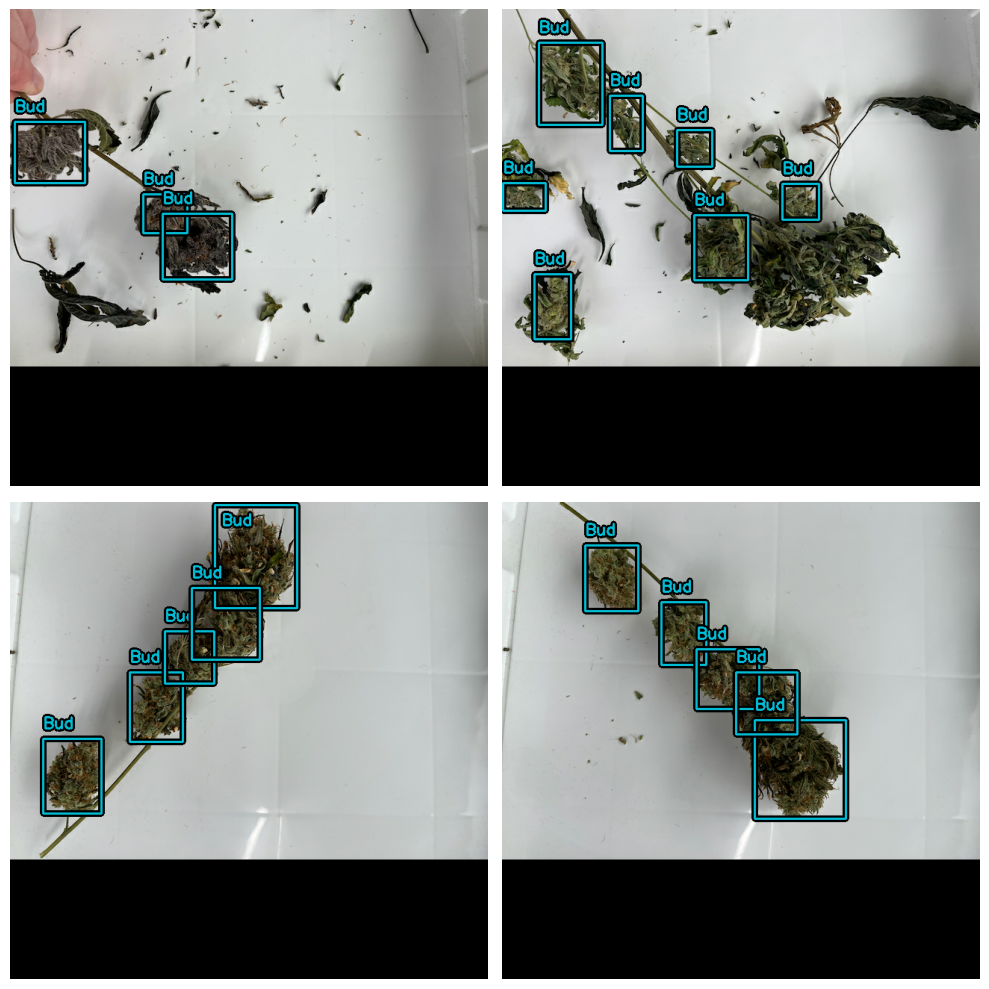

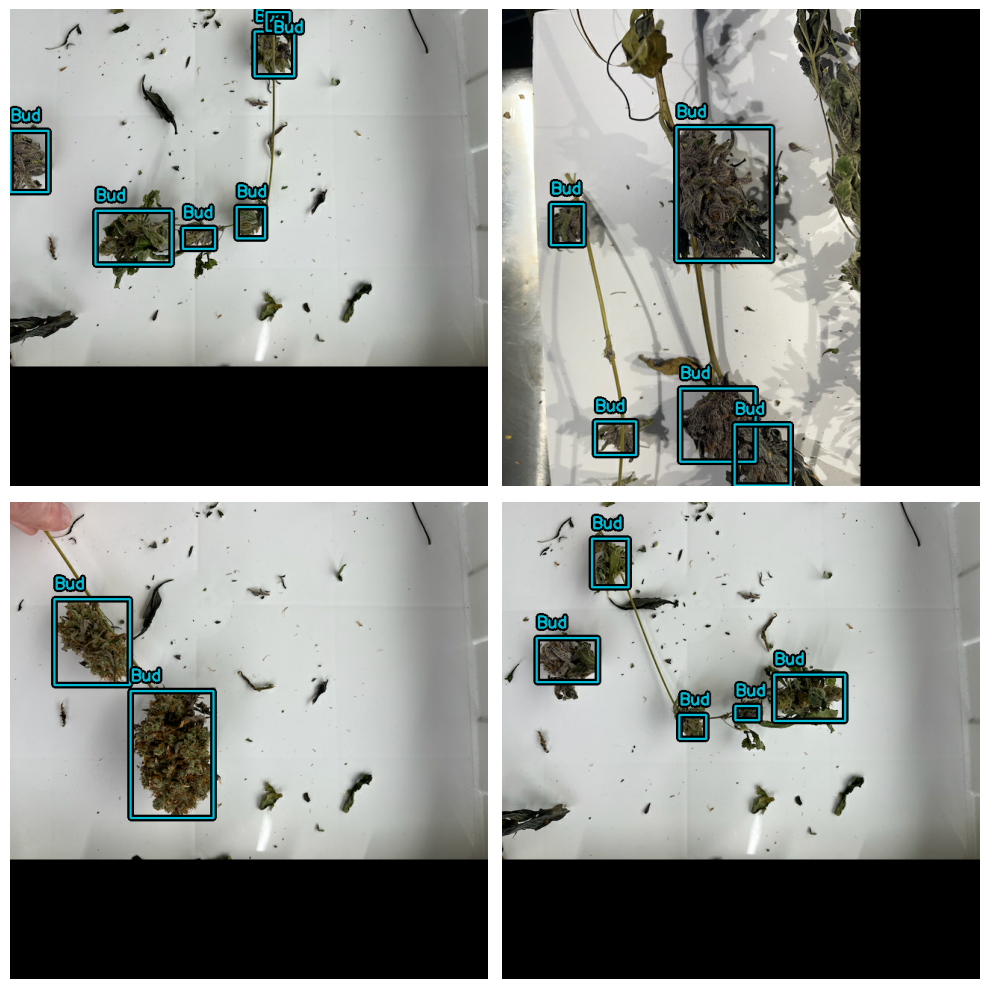

In [12]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [13]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Create The Model

In [14]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [15]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

# Compile the Model

In [16]:
# using optimizers.legacy.Adam instead of optimizers.Adam because of this message:
#
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs,
# please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [17]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path, save_format="tf")  # Save the model when mAP improves

        return logs

# Train the Model

In [18]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.tf")],
)

Epoch 1/3
5/5 [==============================] - ETA: 0s - loss: 329.8728 - box_loss: 2.9463 - class_loss: 326.9265

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self.

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 53s 10s/step - loss: 329.8728 - box_loss: 2.9463 - class_loss: 326.9265 - val_loss: 399.0016 - val_box_loss: 3.4164 - val_class_loss: 395.5852 - MaP: 0.0012 - MaP@[IoU=50]: 0.0058 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 6.4356e-04 - MaP@[area=large]: 0.0030 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0357 - Recall@[max_detections=100]: 0.0857 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0250 - Recall@[area=large]: 0.2000
Epoch 2/3
5/5 [==============================] - 9s 2s/step - loss: 150.6534 - box_loss: 2.8653 - class_loss: 147.7881 - val_loss: 1161.4957 - val_box_loss: 3.3038 - val_class_loss: 1158.1919 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_d

# Visualize Predictions

1/1 [==============================] - 0s 168ms/step


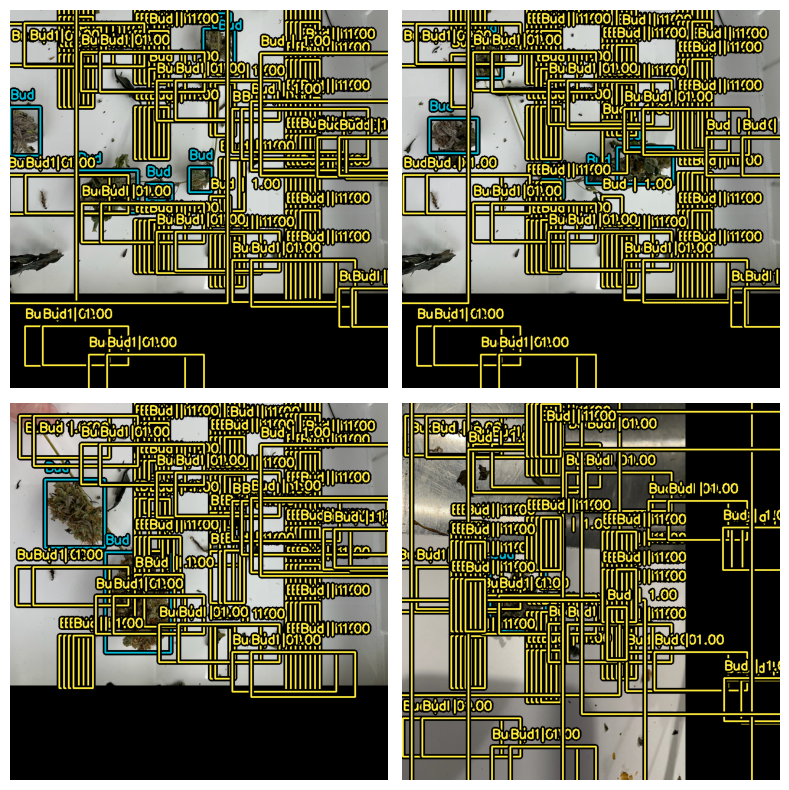

In [19]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")